# Task 

## Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данные находятся в файле /datasets/autos.csv. 
Признаки
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

Целевой признак
 - Price — цена (евро)

# Libs import

In [3]:
# Загрузим нужные библиотеки
try:
    import phik
except ModuleNotFoundError:
    ! pip install phik -q
    import phik

In [4]:
try:
    import shap
except ModuleNotFoundError:
    ! pip install shap -q
    import shap

In [5]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.2.


In [6]:
# стандартные библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import time
from scipy import stats as st
from IPython.display import display

# загружаем нужные модели Регрессии
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier

import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем классы для перебора параметров 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, root_mean_squared_error

# загружаем класс pipeline
from sklearn.pipeline import Pipeline


# загружаем инструменты для анализа DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from shap import TreeExplainer

# загрузим дамми-модели
from sklearn.dummy import DummyRegressor

# Describing function

In [7]:
# Писал сам, улучшал с помощью chatGPT
def df_uni_describe(df: pd.DataFrame) -> None:
    """
    Universal function for describing a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be described.

    This function provides a comprehensive description of the DataFrame including:
    - Main info: Number of variables, number of observations, total missing values, and total duplicates.
    - Missing (NaNs) percentage per column if any.
    - Info of the DataFrame including data types and memory usage.
    - Head of the DataFrame.
    - Descriptive statistics for numerical columns.
    """
    try:
        # Main info
        print("\033[1m" + 'Main info:' + "\033[0m")
        print(f"Number of variables: {df.shape[1]}")
        print(f"Number of observations: {df.shape[0]}")
        
        missing_percentage = df.isna().mean().round(4) * 100
        total_missing = missing_percentage.mean()
        print(f'Total missing: {total_missing:.2f}%')
        print(f'Total duplicates: {df.duplicated().sum()}')

        # Missing values
        if total_missing > 0:
            print("\033[1m" + 'Missing (NaNs), %' + "\033[0m")
            display(missing_percentage.to_frame('NaNs, %').sort_values(by='NaNs, %', ascending=False).style.background_gradient('coolwarm'))

        # Info of dataframe
        print("\033[1m" + 'Info of dataframe:' + "\033[0m")
        df.info()

        # Head of dataframe
        print("\033[1m" + 'Head of dataframe:' + "\033[0m")
        display(df.head(2))

        # Descriptive statistics
        print("\033[1m" + 'Descriptive statistics:' + "\033[0m")
        display(df.describe().T)

    except Exception as e:
        print(f'An error occurred: {e}')

In [8]:
def show_box_hist(col: pd.Series, bins: int = None, show_hist: bool = True, show_boxplot: bool = True) -> dict:
    """
    Plots histogram and boxplot for a given quantitative parameter.

    Parameters:
    - col (pd.Series): Quantitative parameter for analysis.
    - bins (int or sequence, optional): Number of bins for the histogram (default is determined automatically).
    - show_hist (bool, optional): Whether to show histogram (default is True).
    - show_boxplot (bool, optional): Whether to show boxplot (default is True).
    
    Returns:
    - dict: Dictionary with descriptive statistics.
    """
    try:
        # Descriptive statistics
        description = col.describe().to_dict()
        print(f'Description of the column {col.name}:')
        display(pd.DataFrame(description, index=[0]))

        # Determine the layout for the plot
        if show_hist and show_boxplot:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
        elif show_hist or show_boxplot:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
            axs = [axs]  # Ensure axs is iterable as a list
        else:
            print("Both show_hist and show_boxplot are set to False. Nothing to plot.")
            return description

        # Plot histogram
        if show_hist:
            if bins is None:
                bins = 'auto'
            sns.histplot(col, bins=bins, kde=False, ax=axs[0] if show_boxplot else axs[0], color='skyblue')
            axs[0].set_title('Histogram')
            axs[0].set_xlabel(col.name)
            axs[0].set_ylabel('Frequency')

        # Plot boxplot
        if show_boxplot:
            sns.boxplot(x=col, ax=axs[1] if show_hist else axs[0], color='salmon')
            axs[1 if show_hist else 0].set_title('Boxplot')
            axs[1 if show_hist else 0].set_xlabel(col.name)

        plt.tight_layout()
        plt.show()
        
        return description

    except Exception as e:
        print(f'An error occurred: {e}')
        return {}

In [9]:
def cat_col_pie(col: pd.Series, top_n: int = 10):
    """
    Plots pie and bar charts for a given categorical parameter.
    Aggregates all categories beyond the top_n into 'Other'.

    Parameters:
    - col (pd.Series): Categorical parameter for analysis.
    - top_n (int, optional): Number of top categories to display (default is 10).
    
    Returns:
    - dict: Dictionary with counts and proportions of the categories.
    """
    try:
        # Calculate counts and proportions
        value_counts = col.value_counts()
        proportions = value_counts / value_counts.sum()

        # Aggregate the rest into "Other"
        if len(value_counts) > top_n:
            top_values = value_counts.iloc[:top_n]
            other_values = value_counts.iloc[top_n:].sum()
            top_values['Other'] = other_values
            
            top_proportions = proportions.iloc[:top_n]
            other_proportions = proportions.iloc[top_n:].sum()
            top_proportions['Other'] = other_proportions
        else:
            top_values = value_counts
            top_proportions = proportions

        # Display counts and proportions
        print(f'Counts and proportions in column {col.name}:')
        display(pd.DataFrame({
            'Counts': top_values,
            'Proportions': top_proportions
        }).style.format({
            'Proportions': '{:.2%}'
        }))

        # Plot pie chart
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f'Category Distribution in {col.name}')

        top_proportions.plot(kind='pie', ax=axes[0], autopct="%.1f%%", labels=top_proportions.index)
        axes[0].set_title('Pie Chart')
        axes[0].set_ylabel('')

        # Plot bar chart
        top_values.sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='skyblue')
        axes[1].set_title('Bar Chart')
        axes[1].set_xlabel('Counts')

        plt.tight_layout()
        plt.show()
        
        return {
            'Counts': top_values.to_dict(),
            'Proportions': top_proportions.to_dict()
        }

    except Exception as e:
        print(f'An error occurred: {e}')
        return {}

# Load data

In [10]:
pth1 = '/datasets/autos.csv'
pth2 = 'datasets\\autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv('datasets\\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

df_uni_describe(df)

Main info:
Number of variables: 16
Number of observations: 354369
Total missing: 3.19%
Total duplicates: 4
Missing (NaNs), %


,"NaNs, %"
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


Descriptive statistics:


,count,mean,min,25%,50%,75%,max,std
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
RegistrationYear,354369.0,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Power,354369.0,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Kilometer,354369.0,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,1067.0,30165.0,49413.0,71083.0,99998.0,25783.096248
LastSeen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


- 4 явных дубля
- больше всего пропущенных знаечний 
    - 20% в Repaired
    - 10% VehicleType
- NumberOfPictures все значения равны 0 - неинформативно
- RegistrationYear - минимальное занчение 1000, что сомнительно если не продавались древнии телеги на сервисе, а максимальнон 9999 - возможно продавали делорианы?:)
- Kilometer - болшье половины значение = 150 000, видимо искуссвтенное ограничение на сервисе.

In [11]:
# уберем неважные/неинформативные признаки для цены
# - DateCrawled
# - PostalCode
# - NumberOfPictures
# - LastSeen
df = df.drop(['DateCrawled', 'PostalCode', 'NumberOfPictures', 'LastSeen'], axis='columns')
print('размерность датасета до того как убеерм дубликаты', df.shape)
# уберем явные дубликаты
df = df.drop_duplicates()
print('размерность датасета после того как убрали дубликаты', df.shape)

размерность датасета до того как убеерм дубликаты

 (354369, 12)
размерность датасета после того как убрали дубликаты (342535, 12)


# EDA

## Numeric colums analysis

Description of the column Price:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,4397.944549,4511.488765,0.0,1000.0,2700.0,6350.0,20000.0


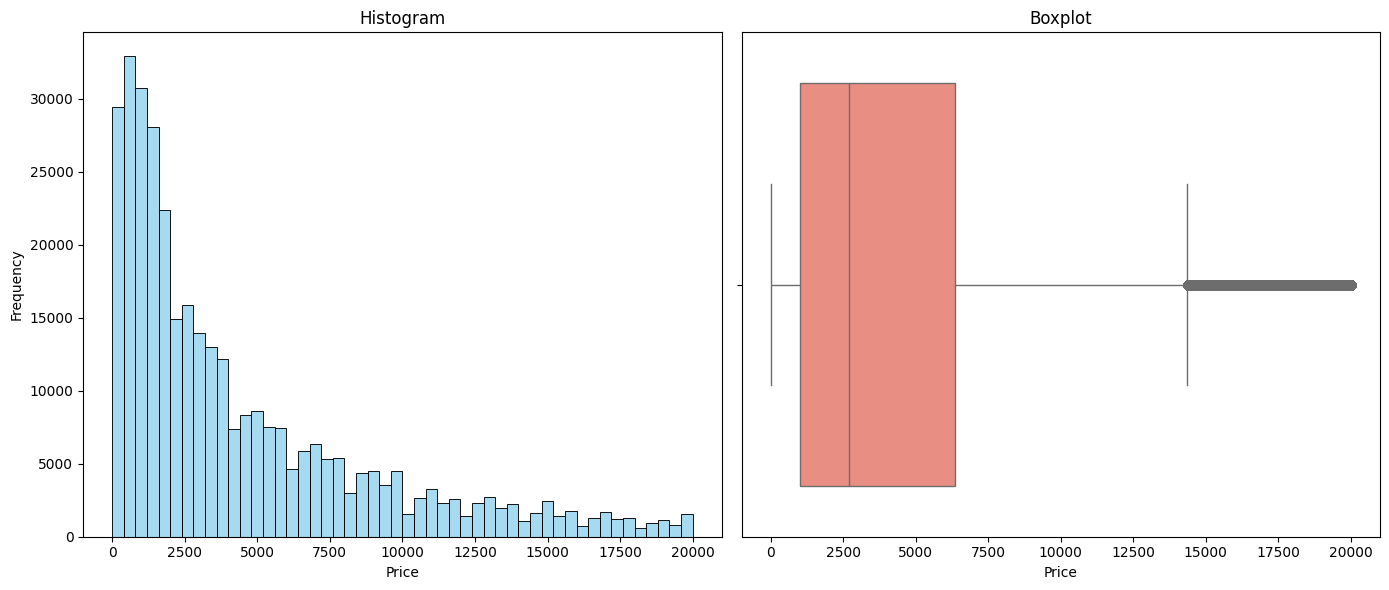

Description of the column RegistrationYear:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,2004.224704,91.1228,1000.0,1999.0,2003.0,2008.0,9999.0


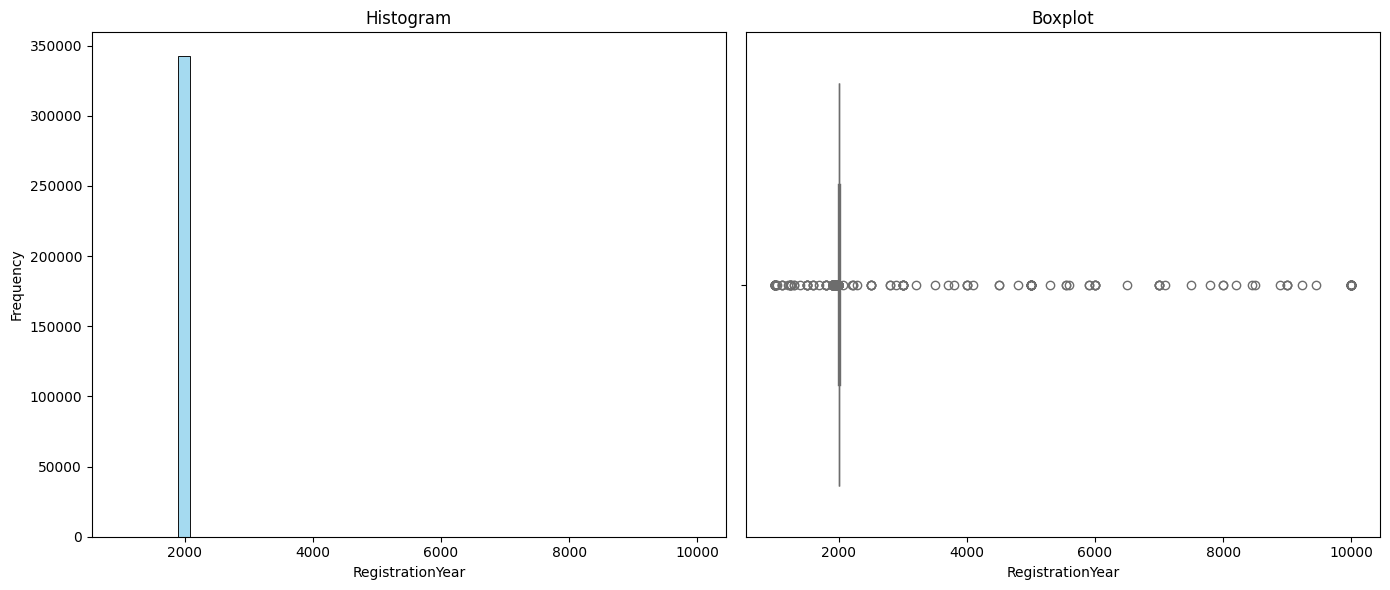

Description of the column Power:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,109.971717,191.86381,0.0,68.0,104.0,141.0,20000.0


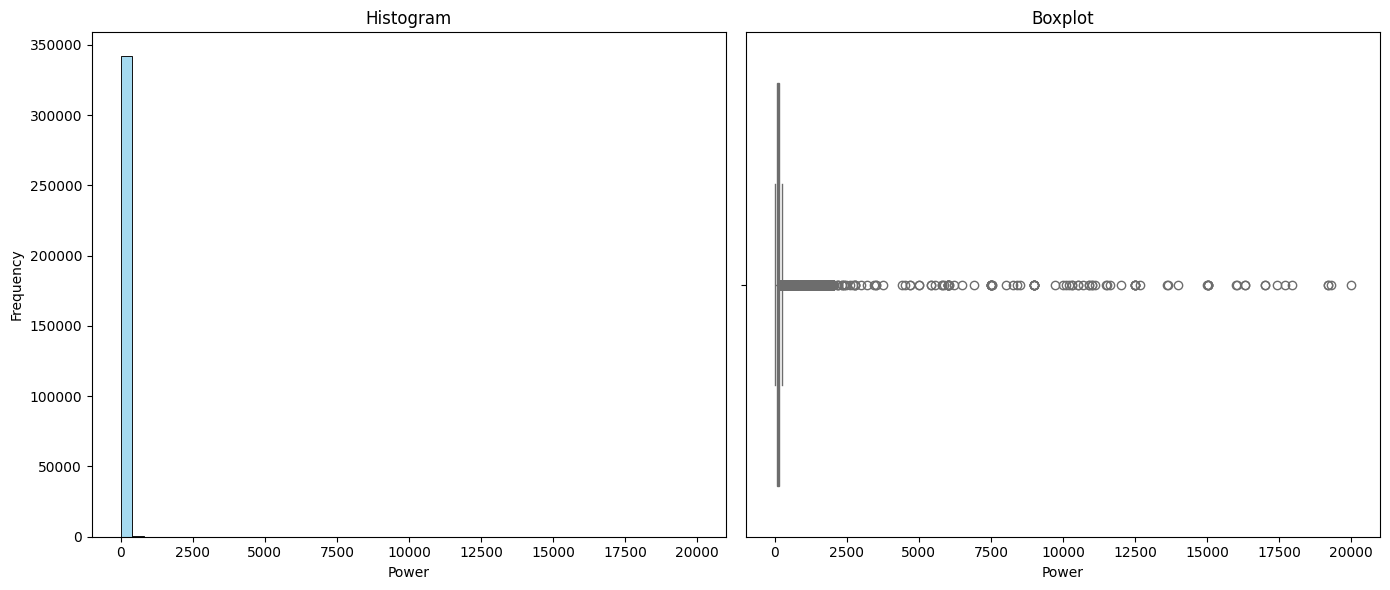

Description of the column Kilometer:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,128226.239654,37926.776381,5000.0,125000.0,150000.0,150000.0,150000.0


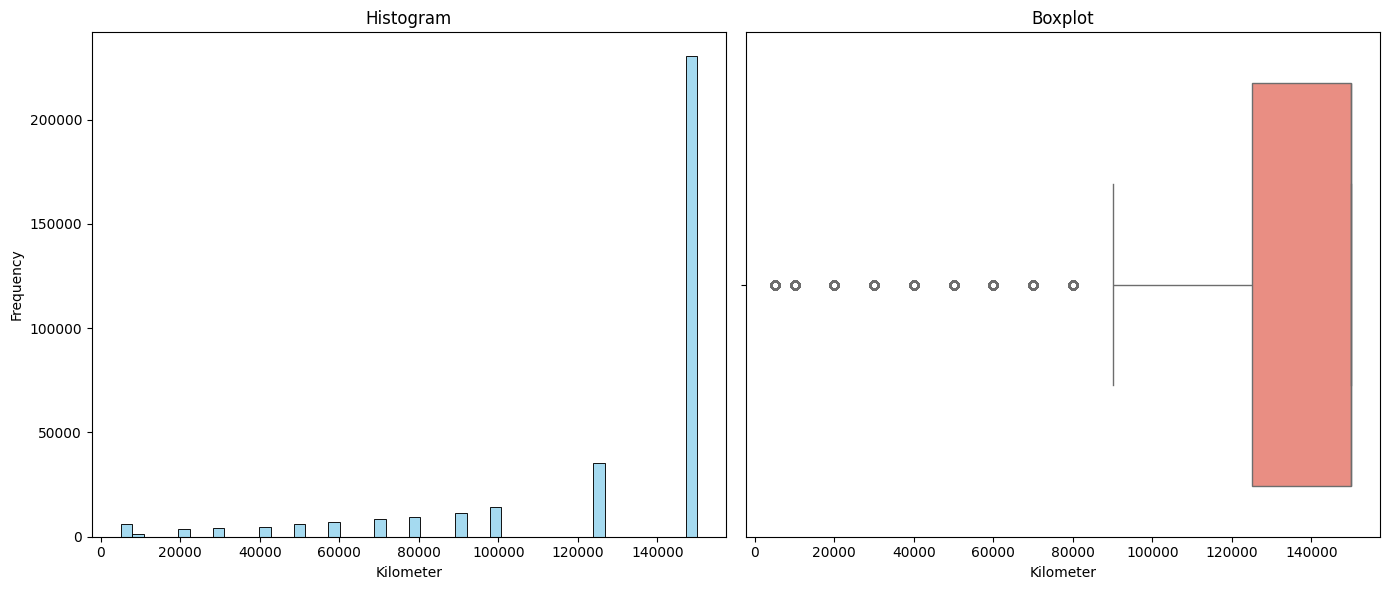

Description of the column RegistrationMonth:


,count,mean,std,min,25%,50%,75%,max
0,342535.0,5.699803,3.729032,0.0,3.0,6.0,9.0,12.0


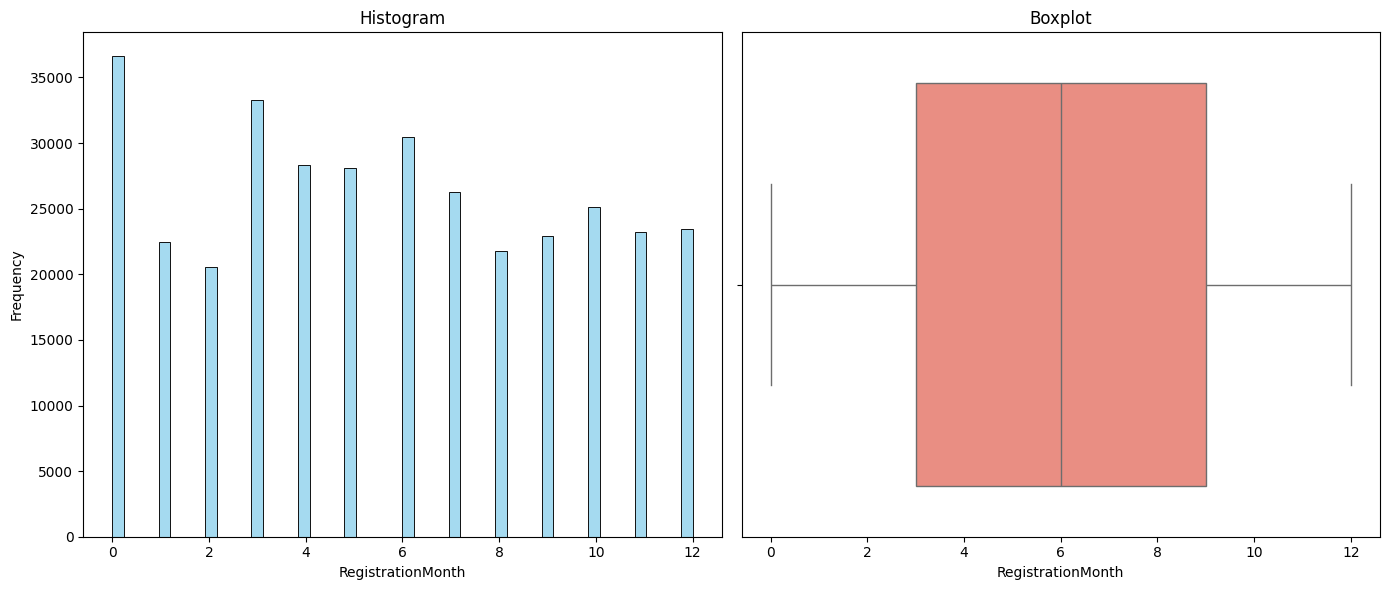

In [12]:
# Оценим количественные признаки 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    show_box_hist(df[col], show_boxplot=True, bins=50)

Выбросы в колонках:
- Power = макисимум 20000 вряд ли отражает реальность
- RegistrationYear  - все что бльше даты загрузки объявления не отражает реальность

## Category columns analysis

Counts and proportions in column VehicleType:


,Counts,Proportions
VehicleType,,
sedan,87954,28.77%
small,77208,25.26%
wagon,62700,20.51%
bus,27877,9.12%
convertible,19516,6.38%
coupe,15675,5.13%
suv,11525,3.77%
other,3238,1.06%


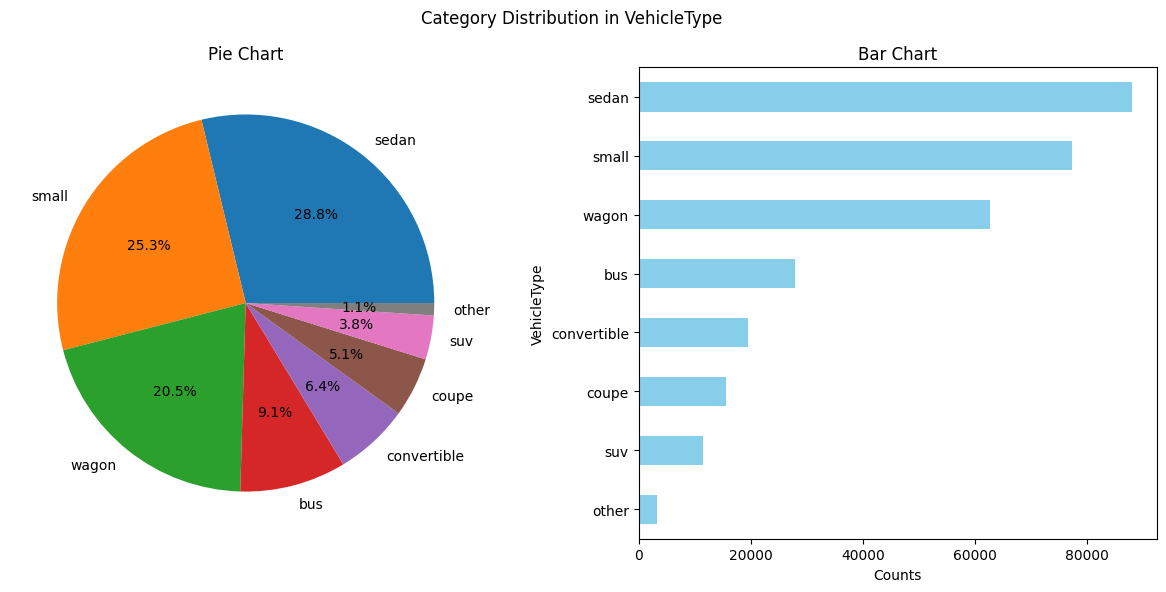

Counts and proportions in column Gearbox:


,Counts,Proportions
Gearbox,,
manual,259569,80.23%
auto,63957,19.77%


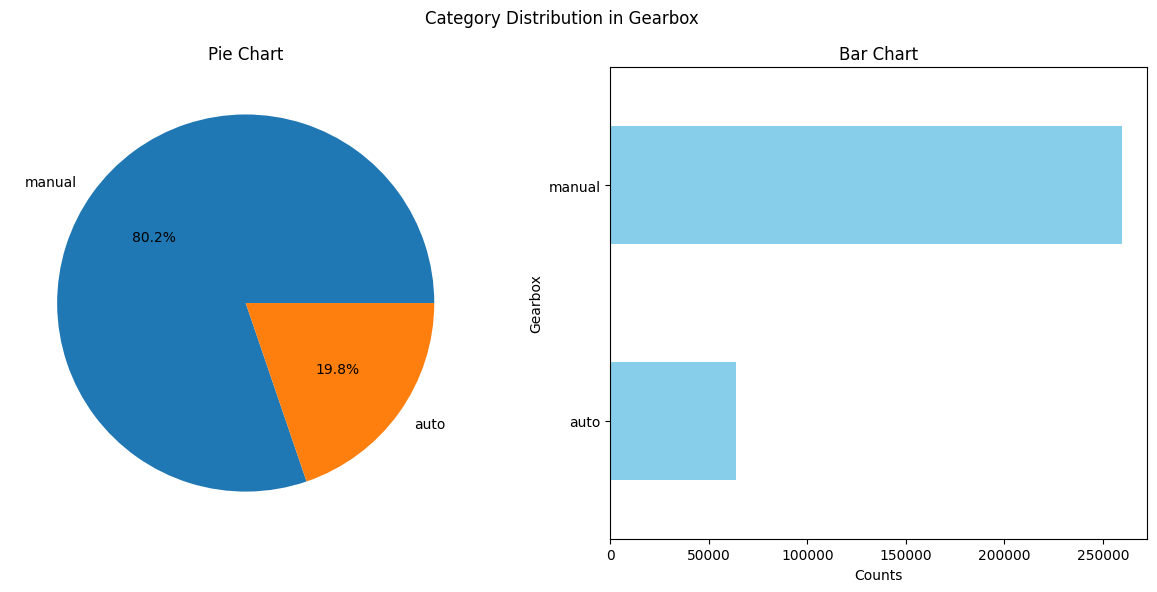

Counts and proportions in column Model:


,Counts,Proportions
Model,,
golf,28111,8.70%
other,23786,7.36%
3er,18988,5.88%
polo,12649,3.91%
corsa,12133,3.75%
astra,10480,3.24%
passat,9708,3.00%
a4,9437,2.92%
c_klasse,7966,2.46%


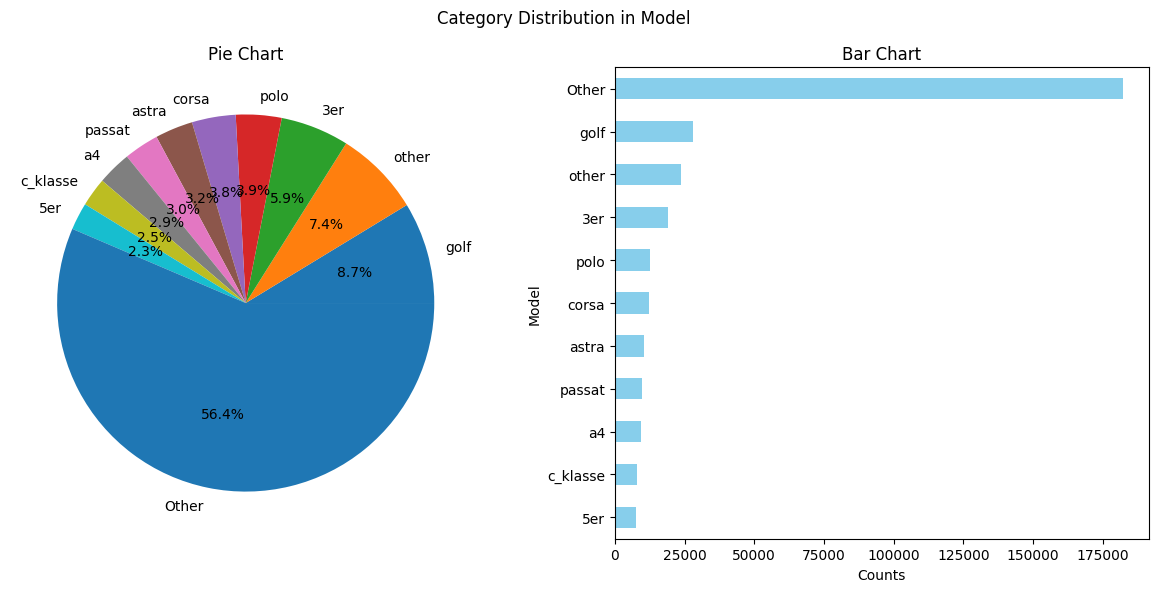

Counts and proportions in column FuelType:


,Counts,Proportions
FuelType,,
petrol,209552,67.56%
gasoline,94445,30.45%
lpg,5112,1.65%
cng,555,0.18%
hybrid,228,0.07%
other,201,0.06%
electric,89,0.03%


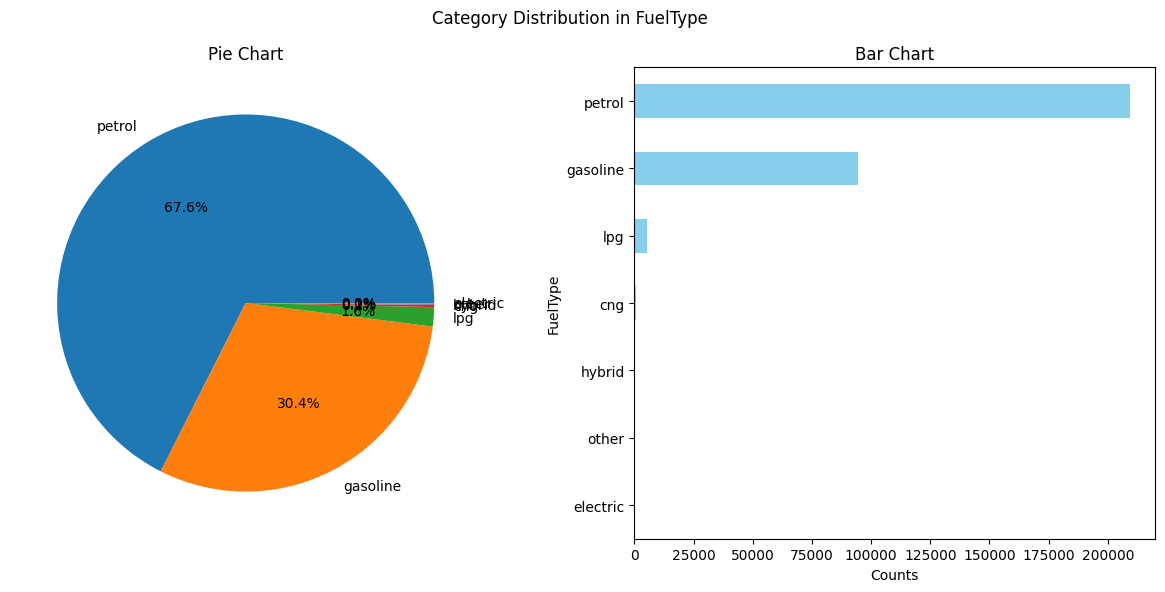

Counts and proportions in column Brand:


,Counts,Proportions
Brand,,
volkswagen,74183,21.66%
opel,38642,11.28%
bmw,35501,10.36%
mercedes_benz,31051,9.07%
audi,28276,8.25%
ford,24412,7.13%
renault,17469,5.10%
peugeot,10629,3.10%
fiat,9361,2.73%


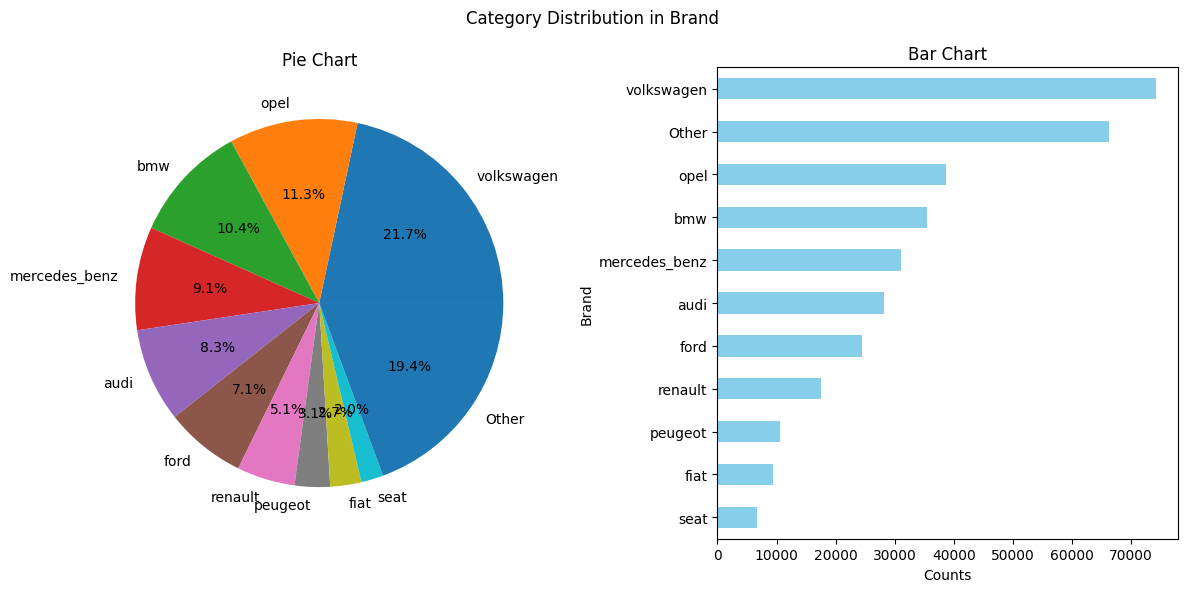

Counts and proportions in column Repaired:


,Counts,Proportions
Repaired,,
no,237631,87.07%
yes,35273,12.93%


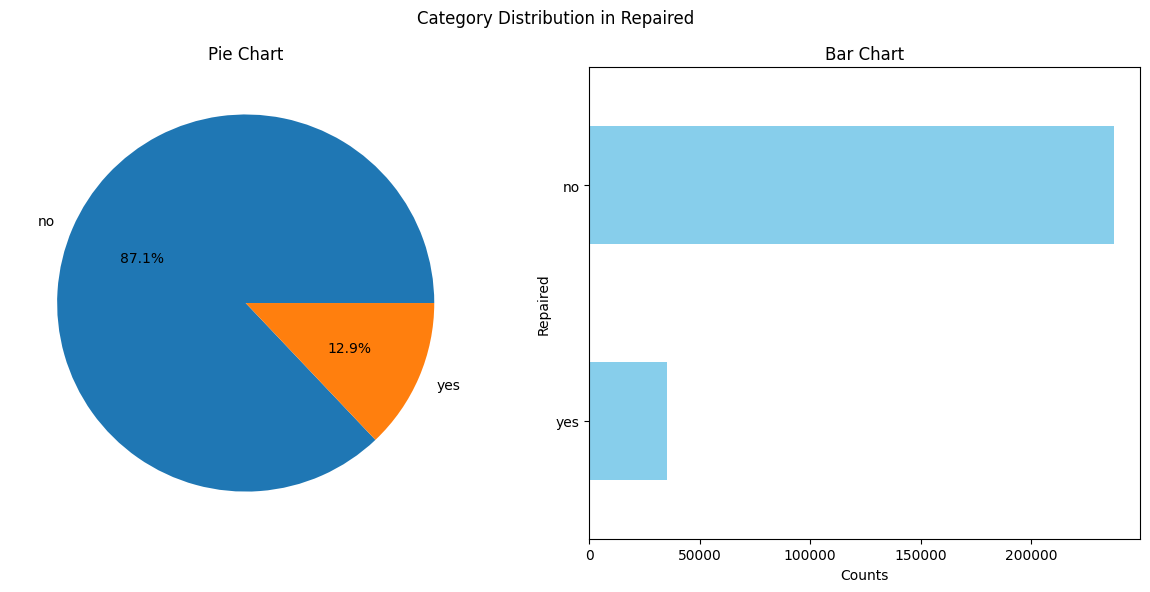

In [13]:
# Оценим качественные признаки 
category_cols = df.select_dtypes(include=['object']).columns

for col in category_cols:
    cat_col_pie(df[col])

In [14]:
len(df['Brand'].unique())

40

In [15]:
len(df['Model'].unique())

251

In [16]:
df['Repaired'].value_counts()

Repaired
no     237631
yes     35273
Name: count, dtype: int64

- 40 брендов
- 251 марка
- Неявных дубликатов не заметил (разве что rover land_rover но это вроде разные компании по Вики.)
- Не было в ремонте 87% машин. Непонятно были или нет в ремонте машины что не указаны, вероятно нужно будет удалить строки с этими пропущенными значениями, так как признак важный, а как его восстанавливать неочевидно. 
- petrol и gasoline это вроде одно и тоже, но вероятно под gasoline имеется ввиду diesel - доля таких машин в Европе судя по интернету как раз примено была такой. 

# Preprocessing

## Outlier

<Axes: >

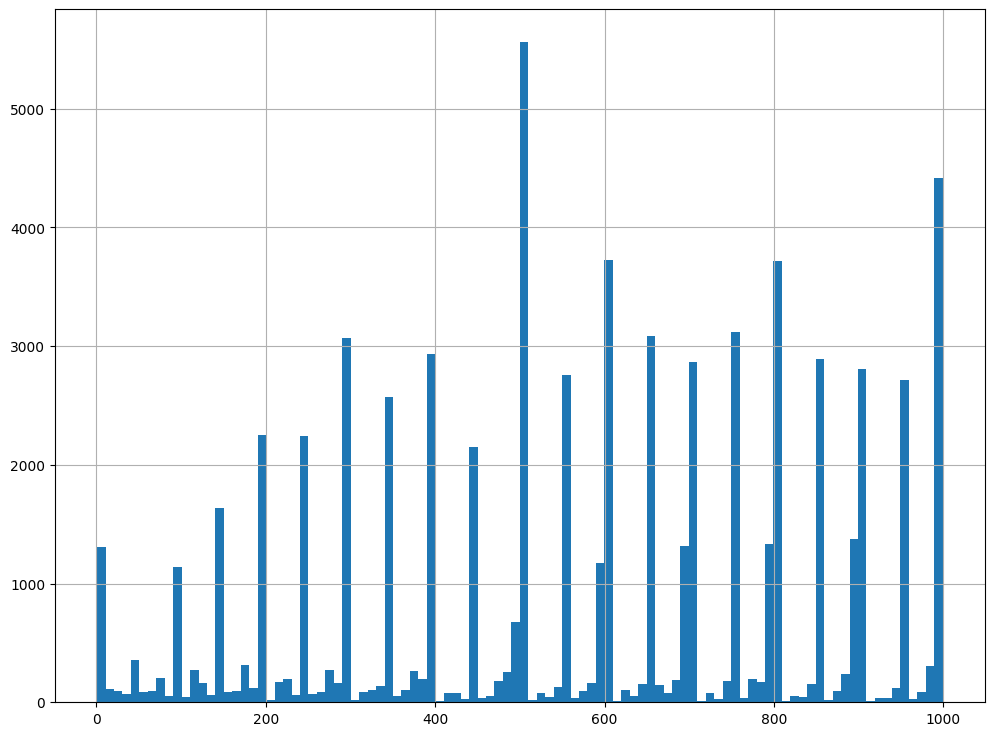

In [17]:
# важно чтобы целевой признак при обучении был логичным. Цена не может быть равной 0 или слишком низкой
df.query('Price > 0 & Price < 1000')['Price'].hist(bins=100, figsize=(12,9))

In [18]:
# удалим из df объявления с ценой 0 Евро
df_filtred = df.copy()
print('До удаления 0 цен', df_filtred.shape)
df_filtred = df_filtred.query('Price > 0')
print('После удаления 0 цен', df_filtred.shape)

До удаления 0 цен (342535, 12)
После удаления 0 цен (332089, 12)


Не нулевые низкие цены удалять не стал, так как, а вдург кто-то продает на металалом?

In [19]:
df_filtred.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'DateCreated'],
      dtype='object')

<Axes: >

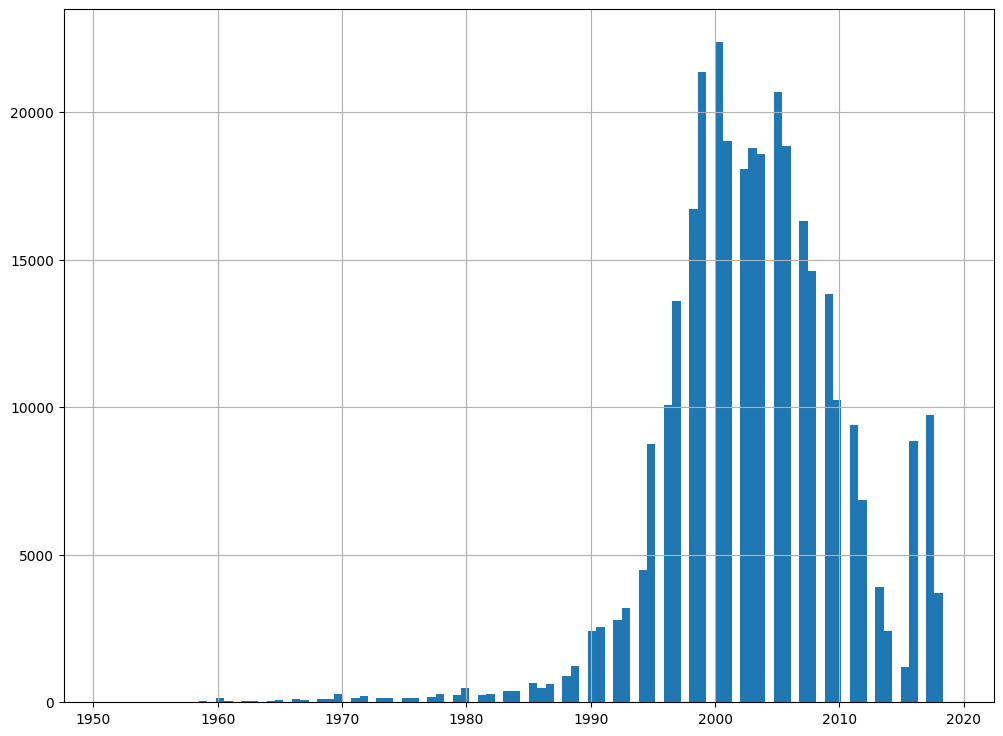

In [20]:
# оставим корректные года регистрации 
df_filtred.query('RegistrationYear > 1950 & RegistrationYear <= 2030')['RegistrationYear'].hist(bins=100, figsize=(12,9))

датасет явно собирася примерно до 2018 года

In [21]:
df_filtred = df_filtred.query('RegistrationYear >= 1955 & RegistrationYear <= 2020')

Судя по [вики](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output) самый мощный автомобиль это 1715 л.с. Koenigsegg Gemera. И производится он в 2023 году, ранее были менее мощные до 1500 л.с.

In [22]:
df_filtred.query('Power >= 1500')['Model'].unique()

array(['lupo', 'zafira', 'focus', '5er', 'e_klasse', 'c5', '3er', 'caddy',
       'golf', 'other', 'aygo', 'escort', 'transporter', 'mondeo',
       'fortwo', 'seicento', 'polo', nan, 'c_klasse', 'berlingo', 'omega',
       'sprinter', 'vectra', 'a6', 'astra', 'passat', 'stilo', 'ibiza',
       'megane', 'ceed', '80', '1er', 'octavia', 's_klasse', 'twingo',
       'cooper', 'corsa', '147', 'agila', 'fiesta', 'galaxy', 'a3', 'rav',
       'clk', 'laguna', 'bravo', 'scenic', 'spark', 'a4', 'nubira',
       'kangoo', 'toledo', 'tt', 'up', 'a8', 'touareg', 'clio', 'tiguan',
       'c_max', 'punto', 'a_klasse', 'carisma'], dtype=object)

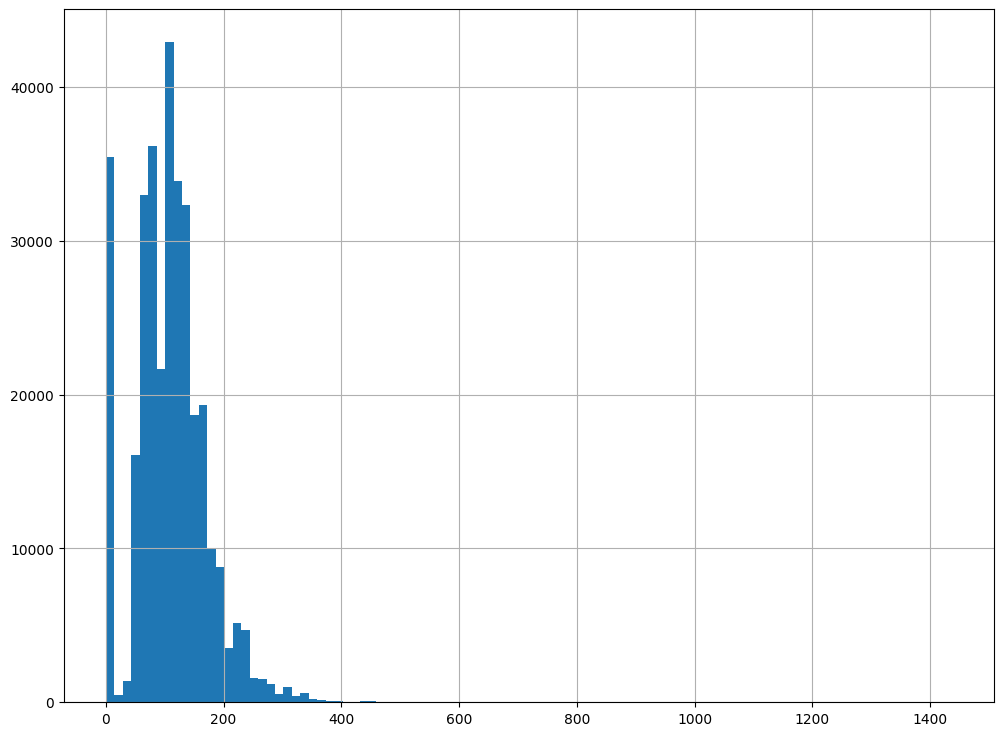

In [23]:
ax = df_filtred.query('Power < 1500')['Power'].hist(bins=100, figsize=(12,9))

187 строк с обычными вполне брендами. 
Более 500 л.с - очень редкие значения. 
Обнулим высокие значения мошности, а далее заполним 0 значения модой внутри модели. У нас датасет относительно большой, можно конечно и удалить, но на малых я бы делал так

In [24]:
df_filtred.loc[df_filtred['Power'] > 500, 'Power'] = np.NaN

## Missing values preprocessing

- где нам неизвестно ремонтировалась или нет машина - поставим unknown значения. 
- VehicleType - наиболее часто встречающиеся знаяения внутри Model
- FuelType  - восстановим по моде внутри Model
- Model - нет вижу хорошего способа восстановить - поставим unknown значения. 
- Power - пропущенные знаечния заполним медианой внутри модели
- Gearbox - восстановим по моде внутри Model

In [25]:
# где нам неизвестно 'Repaired' - поставим unknown значения. 
df_filtred['Repaired'] = df_filtred['Repaired'].fillna('unknown')

In [26]:
# VehicleType - наиболее часто встречающиеся знаяения внутри Model, а где неизвестно 'unknown'
df_filtred['VehicleType'] = df_filtred['VehicleType'].fillna(df_filtred
                                         .groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

df_filtred['VehicleType'] = df_filtred['VehicleType'].fillna('unknown')

In [27]:
# FuelType - наиболее часто встречающиеся знаяения внутри Model, а где неизвестно 'unknown'
df_filtred['FuelType'] = df_filtred['FuelType'].fillna(df_filtred
                                         .groupby('Model')['FuelType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

df_filtred['FuelType'] = df_filtred['FuelType'].fillna('unknown')

In [28]:
# пропущенные знаечния заполним медианой внутри модели, а где неизвестно - мдеианой по всем
df_filtred['Power'] = df_filtred['Power'].fillna(df_filtred
                                                 .groupby('Model')['Power']
                                                 .transform('median'))

df_filtred['Power'] = df_filtred['Power'].fillna(df_filtred['Power'].median())

In [29]:
print("Количество объявлений с неизвестной Model:", len(df_filtred.loc[df_filtred['Model'].isna()]))

Количество объявлений с неизвестной Model: 17129


Довольно много. Заменим пропущенны Model 'unknown'

In [30]:
df_filtred['Model'] = df_filtred['Model'].fillna('unknown')

In [31]:

df_filtred['Gearbox'] = df_filtred['Gearbox'].fillna(df_filtred
                                                     .groupby('Model')['Gearbox']
                                                     .transform(lambda x: x.value_counts().idxmax())
                                                    )

In [32]:
print(df_filtred.isna().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
dtype: int64


In [33]:
###  поиск на неявные дубли. 
cat_col = df_filtred.select_dtypes(include=['object']).columns
for col in cat_col:
    print(col, ':', df_filtred[col].unique())

VehicleType : ['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other'
 'unknown']
Gearbox : ['manual' 'auto']
Model : ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus'
 'tt' 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' '

In [34]:
df_uni_describe(df_filtred)

Main info:
Number of variables: 12
Number of observations: 331772
Total missing: 0.00%


Total duplicates: 289
Info of dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 331772 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              331772 non-null  int64         
 1   VehicleType        331772 non-null  object        
 2   RegistrationYear   331772 non-null  int64         
 3   Gearbox            331772 non-null  object        
 4   Power              331772 non-null  float64       
 5   Model              331772 non-null  object        
 6   Kilometer          331772 non-null  int64         
 7   RegistrationMonth  331772 non-null  int64         
 8   FuelType           331772 non-null  object        
 9   Brand              331772 non-null  object        
 10  Repaired           331772 non-null  object        
 11  DateCreated        331772 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usa

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
0,480,sedan,1993,manual,0.0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,2016-03-24


Descriptive statistics:


,count,mean,min,25%,50%,75%,max,std
Price,331772.0,4535.656005,1.0,1200.0,2850.0,6500.0,20000.0,4511.213873
RegistrationYear,331772.0,2003.197666,1955.0,1999.0,2003.0,2008.0,2019.0,7.212399
Power,331772.0,107.261597,0.0,69.0,105.0,143.0,500.0,62.58055
Kilometer,331772.0,128435.793256,5000.0,125000.0,150000.0,150000.0,150000.0,37429.70779
RegistrationMonth,331772.0,5.765381,0.0,3.0,6.0,9.0,12.0,3.700221
DateCreated,331772,2016-03-20 19:27:29.542456832,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN


In [35]:
# убеерм полные дубликаты что у нас повились
df_filtred.drop_duplicates(inplace=True)

In [36]:
# созданим новые колонки по дате создания объявления
df_filtred['CreatedYear'] = df_filtred['DateCreated'].dt.year
df_filtred['CreatedMonth'] = df_filtred['DateCreated'].dt.month
df_filtred.drop(columns='DateCreated', inplace=True)

In [46]:
df_filtred.head().T

,0,1,2,3,4
Price,480,18300,9800,1500,3600
VehicleType,sedan,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0.0,190.0,163.0,75.0,69.0
Model,golf,unknown,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline
Brand,volkswagen,audi,jeep,volkswagen,skoda


# Models training

In [37]:
RANDOM_STATE = 42 # просто понравилось

# Выделим train и тест

X = df_filtred.drop(['Price'], axis=1)
y = df_filtred['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=RANDOM_STATE
)

In [38]:
# найдем реузльтаты DummyRegression
model_dummy = DummyRegressor(strategy='median')

In [39]:
%time model_dummy.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 3 ms


DummyRegressor(strategy='median')

In [40]:
%time prediction_dummy = model_dummy.predict(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [41]:
rmse_dummy = int(root_mean_squared_error(y_test, prediction_dummy))
print('Метрика RMSE на dummy модели', rmse_dummy)

Метрика RMSE на dummy модели 4786


In [42]:
df_filtred.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'CreatedYear', 'CreatedMonth'],
      dtype='object')

In [43]:
# категориальные и числовые столбцы
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'DateCreated']
numerical_features = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'CreatedYear', 'CreatedMonth']

## Linear Regression

In [47]:
# предобработка
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# пайплайн с предобработкой и обучением
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# гиперпараметры
param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Проведение поиска по сетке с кросс-валидацией
lr_grid_search = GridSearchCV(lr_pipeline, 
                           param_grid, 
                           cv=5, 
                           scoring=root_mean_squared_error, 
                           n_jobs=-1)

In [48]:
%%time 
lr_grid_search.fit(X, y)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'DateCreated'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\__init__.py", line 505, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'DateCreated'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 906, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 496, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ulyssesid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\__init__.py", line 513, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [2]:
# Вывод лучших гиперпараметров
print("Лучшие параметры:", lr_grid_search.best_params_)

# Вывод RMSE на обучающем наборе
y_pred = lr_grid_search.predict(X)
rmse = root_mean_squared_error(y, y_pred)
print("Корень среднеквадратической ошибки (RMSE):", rmse)

NameError: name 'lr_grid_search' is not defined